In [1]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [18]:
# limit GPU growth

In [9]:
from datasets import get_dataset
from blocks import *
from losses import *
from utils import *

In [2]:
# config
data_loader_train = "../FUNIT/datasets/animals/"
data_list_train = "../FUNIT/datasets/animals_list_train.txt"
data_loader_test = ""
data_list_test = ""
crop_size = (128,128) #(height,width)
resize_size = (140,140)

In [ ]:
import argparse
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--config',
                        type=str,
                        default='../FUNIT/configs/funit_animals.yaml',
                        help='configuration file for training and testing')
    parser.add_argument('--batch_size', type=int, default=0)
    parser.add_argument('--output_path',
                        type=str,
                        default='.',
                        help="outputs path")
    parser.add_argument('--test_batch_size',
                         type=int,
                         default=4)
    opts = parser.parse_args()
    config = get_config(opts.config)
    
    epochs = config['max_iter']
    if opts.batch_size != 0:
        config['batch_size'] = opts.batch_size
        
    # Networks
    networks = FUNIT(config)

    # Datasets
    datasets = get_datasets(config)
    train_content_dataset = datasets[0]
    train_class_dataset = datasets[1]
    train_dataset = tf.data.Dataset.zip((train_content_dataset, train_class_dataset))
    test_content_dataset = datasets[2]
    test_class_dataset = datasets[3]
    test_dataset = tf.data.Dataset.zip((train_content_dataset, train_class_dataset))
    
    # Mean loss
    lossnames = ["G_loss","D_loss"]
    metrics_list = []
    for itemname in lossnames:
        metrics_list.append(tf.keras.metrics.Mean(itemname, dtype=tf.float32))
    
    for epoch in range(epochs):
        for (co_data, cl_data) in train_dataset:
            train_returns = train_step(co_data,cl_data,config)
            for idx, itemname in enumerate(lossnames):
                metrics_list[idx](train_returns[itemname])
                
        for idx, itemname in enumerate(lossnames):
            print("    {}: {:.4f}".format(itemname,metrics_list[idx].result()))
        for metric in metrics_list:
            metric.reset_states()
            
        if epoch % config['image_save_iter'] == 0 or\
           epoch % config['image_display_iter'] == 0:
            if epoch % config['image_save_iter'] == 0:
                key_str = '%08d' % (epoch + 1)
            else:
                key_str = 'current'
            output_train_dataset = train_dataset.take(opts.test_batch_size)
            output_test_dataset = test_dataset.take(opts.test_batch_size)
            for idx, (co_data, cl_data) in output_train_dataset.enumerate():
                test_returns = test_step(co_data,cl_data,config)
                write_images(zip(test_returns['xa'],test_returns['xr'],test_returns['xt'],test_returns['xb']), 
                             test_returns['display_list'],
                             'train_%s_%02d' % (key_str, idx)
                             max(config['crop_image_height'], config['crop_image_width']))
            for idx, (co_data, cl_data) in output_test_dataset.enumerate():
                test_returns = test_step(co_data,cl_data,config)
                write_images(zip(test_returns['xa'],test_returns['xr'],test_returns['xt'],test_returns['xb']), 
                             test_returns['display_list'],
                             'test_%s_%02d' % (key_str, idx)
                             max(config['crop_image_height'], config['crop_image_width']))
                

In [ ]:
# @tf.function
def train_step(nets,co_data,cl_data,config):
    xa, la = co_data
    xb, lb = cl_data
    return_items = {}
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        xt, xr, xa_gan_feat, xb_gan_feat = nets.gen_update(co_data,cl_data,config)
        resp_real, real_gen_feat, xt, resp_fake, fake_gan_feat = nets.dis_update(co_data,cl_data,config)
        
        # Generator - GAN loss
        l_adv_t = GANloss.gen_loss(xt,lb)
        l_adv_r = GANloss.gen_loss(xr,la)
        l_adv = 0.5 * (l_adv_t + l_adv_r)
        # Generator - Reconstruction loss
        l_x_rec = recon_loss(xr, xa)
        # Generator - Feature Matching loss
        _, xr_gan_feat = nets.dis(xr, la)
        _, xt_gan_feat = nets.dis(xt, lb)
        l_c_rec = featmatch_loss(xr_gan_feat, xa_gan_feat)
        l_m_rec = featmatch_loss(xt_gan_feat, xb_gan_feat)
        
        G_loss = config['gan_w'] * l_dav +\
                 config['r_w'] * l_x_rec +\
                 config['fm_w'] * (l_c_rec + l_m_rec)
        
        # Discriminator - GAN loss
        l_real = GANloss.dis_loss(xb, lb, 'real')
        l_fake = GANloss.dis_loss(xt, lb, 'fake')
        # Discriminator - Gradient Penalty
        # ??? grad_dout = autograd.grad(...)[0]
        l_reg = gradient_penalty(resp_real, xb)
        
        D_loss = config['gan_w'] * l_real +\
                 config['gan_w'] * l_fake +\
                 10 * l_reg
        
    # Update Gradient
    # - Gradient computing
    gen_grad = g_tape.gradient(G_loss, nets.gen.trainable_variables)
    dis_grad = d_tape.gradient(D_loss, nets.dis.trainable_variables)
    # - Optimizer
    nets.opt_gen.apply_gradients(zip(gen_grad, nets.gen.trainable_variables))
    nets.opt_gen.apply_gradients(zip(dis_grad, nets.dis.trainable_variables))
    
    return_items['G_loss'] = G_loss.numpy()
    return_items['D_loss'] = D_loss.numpy()
    return return_items

def test_step(nets,co_data,cl_data,config):
    xa, la = co_data
    xb, lb = cl_data
    return_items = {}
    xt, xr, xa_gan_feat, xb_gan_feat = nets.gen_update(co_data,cl_data,config)
    return_items['xa'] = xa.numpy()
    return_items['xb'] = xb.numpy()
    return_items['xr'] = xr.numpy()
    return_items['xt'] = xt.numpy()
    return_items['display_list'] = ['xa','xr','xt','xb']
    return return_items

In [ ]:
# List of working processes of output.
#================================ TensorBoard (later)
#================================ Check Points (later)
#================================ Distributed Training (later)

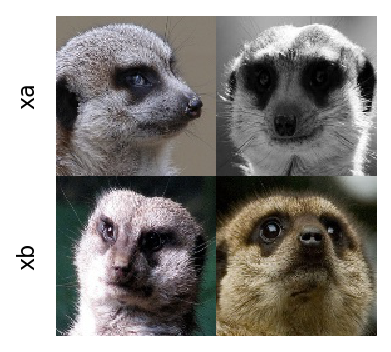

In [278]:
nrow = 2
ncol = 2
fig = plt.figure(figsize=(ncol+1, nrow+1),dpi=128) 

display_list = ["xa","xb"]

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1))

# inputs: (xa,xr,xt,xb) -> [0](N,H,W,C)
# Left to right first, Top to bottom
for i in range(nrow):
    for j in range(ncol):
        idx = i * 2 + j
        ax = plt.subplot(gs[i,j])
        ax.imshow(imgs[idx])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(axis=u'both', which=u'both',length=0)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0)
        if j == 0:
            plt.ylabel(display_list[i])
plt.savefig('test.png',bbox_inches='tight')

In [5]:
test1 = tf.random.normal([2,25,25,32])
test2 = tf.random.normal([2,128])

In [4]:
# block = ContentEncoder(3,2,64,'in','relu','reflect')
# block = ClassEncoder(4,64,64,'none','relu','reflect')
# block = Decoder(3,2,32,3,'relu','reflect')
# block = MLP(32,256,3,'relu')

In [6]:
result = block(test2)